In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Prepare Dataset 

In [5]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset

data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))

def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))



ind = int(0.8 * len(index))

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)

# Test Utilities 

## Model generation 

In [10]:
dim_triu = dim * (dim + 1) // 2

In [8]:
intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def build_model(activation, structure, learning_rate):



    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(dim_triu, activation=activation, input_dim=dim_triu, kernel_initializer=intializer, bias_initializer='zeros'))

    # hidden
    for layer in structure:

        model.add(keras.layers.Dense(
                layer, 
                activation=activation, 
                kernel_initializer=intializer, 
                #bias_initializer='zeros',
                #kernel_regularizer=keras.regularizers.l2(1e-8)
        ))


    #output
    model.add(keras.layers.Dense(dim_triu))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='MSE', metrics=['mae', 'mse'])
    
    return model

## Training 

In [36]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-7, 
    patience=5, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-5, 
    cooldown=10, 
    min_lr=1e-10
)

In [37]:
n_tests = 2#5
n_resets = 1
epochs = 10000


def test_model(structure, activation, learning_rate=1e-4):
    error = []
    
    for i in range(n_tests):
        
        keras.backend.clear_session()
        model = build_model(activation, structure, learning_rate)
        
        for j in range(n_resets):
            keras.backend.set_value(model.optimizer.lr, learning_rate)
            
            history = model.fit(
                x = s_train,
                y = p_train,
                epochs=epochs,
                shuffle=True,
                validation_data=(s_test, p_test), 
                verbose=0, 
                callbacks=[
                    early_stopping, 
                    reduce_lr
                ]
            )
        
        error.append(np.min(history.history["val_mean_absolute_error"]))
        
        print(" - Test " + str(i+1) + ": " + str(error[-1]))
    
    return error

def run_layer_test_series(activation, structures, learning_rate):
    error = []
    for structure in structures:
        print("Layers: " + str(structure))
        error.append(test_model(structure, activation, learning_rate=learning_rate))
    return error

# Testing 

In [38]:
structures = [
        [dim_triu, dim_triu],
        #[dim_triu, dim_triu, dim_triu],
        #[dim_triu + 100, dim_triu + 100],
        [dim_triu + 250, dim_triu + 150, dim_triu + 50],
        #[dim_triu + 100, dim_triu + 200, dim_triu + 100],
        #[dim_triu * 2]
    ]
        
learning_rates = [1e-3, 1e-4]#, 1e-5]

In [48]:
res = []
for lr in learning_rates:
    print("# lr" + str(lr))
    res.append(run_layer_test_series('elu', structures, lr))

# lr0.001
Layers: [351, 351]

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 00043: early stopping
 - Test 1: 0.011192191925029554

Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00069: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00086: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00101: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00143: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00157: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 00168: early stopping
 - Test 2: 0.005693463138327818
Layers: [601, 501, 401]

Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 00052: earl

In [50]:
x = [ 
    s for s in range(len(structures)) for i in range(n_tests)
]

In [51]:
def structure_string(structure):
    return "_".join(list(map(str,list(structure))))
structure_string(structures[0])

'351_351'

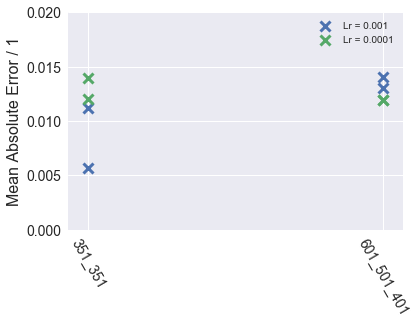

In [65]:
for r, lr in zip(res, learning_rates):
    plt.scatter(x, np.array(r).flatten(), marker="x", label="Lr = " + str(lr) )

#plt.xlabel("Number of Hidden Layers / 1")
plt.ylabel("Mean Absolute Error / 1")

plt.xticks(
    np.arange(len(structures)),
    [structure_string(structure) for structure in structures],
    rotation=-60
)

plt.ylim(0, 0.02)

plt.legend()

plt.show()

In [64]:
(5e-3)**2

2.5e-05